# Toronto Neighborhood Clustering

_For Coursera Capstone week 3 Peer-graded Assignment: "Segmenting and Clustering Neighborhoods in Toronto"_

## Table of Contents

1. [Data Wrangling and Cleaning](#clean)
    
2. [Explore Neighborhoods in Toronto](#explore)
    
3. [Cluster Neighborhoods in Toronto](#cluster)

4. [Examine Clusters](#examine)

5. [Conclusion](#conclusion)

In [2]:
# install and import required packages
import pandas as pd
import numpy as np
import io
import requests

from foursquare import fetch_venues, rank_venues_by_frequency
from geocoder import enrich_neighborhoods_with_geocoder, map_neighborhoods

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

# !conda install -c conda-forge folium=0.10.1 --yes
import folium

## 1. Wrangle and Clean Toronto Neighborhood Data
<a id="clean"></a>

The data for clustering Toronto's neighborhoods will be sourced by wikipedia. This dataset is indexed by postal code and needs to be scrubbed for unassigned zones.

In [2]:
wiki_url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

html_content=requests.get(wiki_url).content
df = pd.read_html(html_content)[0]
df.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [3]:
# Rename columns
df.columns = ['PostalCode', 'Borough', 'Neighborhood']
df.head()

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [4]:
# Ignore cells with a borough that is 'Not assigned'
unassigned_boroughs_indeces = df[df['Borough'] == 'Not assigned'].index
df.drop(unassigned_boroughs_indeces, inplace=True)
df

,PostalCode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor
...,...,...,...
281,M8Z,Etobicoke,Kingsway Park South West
282,M8Z,Etobicoke,Mimico NW
283,M8Z,Etobicoke,The Queensway West
284,M8Z,Etobicoke,Royal York South West


In [5]:
# Examine dataframe for 'Not assigned' neighborhoods
df[df['Neighborhood'] == 'Not assigned']

,PostalCode,Borough,Neighborhood
7,M7A,Queen's Park,Not assigned


In [6]:
# Name 'Not assigned' neighborhoods after borough name
df.loc[df['Neighborhood'] == 'Not assigned', 'Neighborhood'] = df['Borough']

# Check that out transformation worked - mask applied to dataframe should be empty
df[df['Neighborhood'] == 'Not assigned']

,PostalCode,Borough,Neighborhood


In [7]:
formatted_df = df.groupby(['PostalCode', 'Borough'], as_index=False).agg({'Neighborhood': lambda x: ', '.join(x)})
formatted_df.reset_index()
formatted_df

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
...,...,...,...
98,M9N,York,Weston
99,M9P,Etobicoke,Westmount
100,M9R,Etobicoke,"Kingsview Village, Martin Grove Gardens, Richv..."
101,M9V,Etobicoke,"Albion Gardens, Beaumond Heights, Humbergate, ..."


In [8]:
formatted_df.shape

(103, 3)

### Combine wikipedia data with geocoder data

Since Wikipedia dataset does not include zip code coordinates, we should hydrate dataset with longitude and latitude from Geocoder in order to access Foursquare data.

**Instead of following instructions tightly** I've elected to move forward with the original dataset grouped by neighborhood. If we want to cluster neighborhoods, we want their coordinates to pass into Foursquare, not a grouping of zip codes.

In [9]:
df.describe()

,PostalCode,Borough,Neighborhood
count,210,210,210
unique,103,11,207
top,M9V,Etobicoke,Runnymede
freq,8,44,2


In [10]:
# We expected all Neighborhood values to be unique
# In fact, to do the same analysis as NYC, we do not need postal code at all
df.drop("PostalCode", axis=1, inplace=True)
df.info()
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210 entries, 2 to 285
Data columns (total 2 columns):
Borough         210 non-null object
Neighborhood    210 non-null object
dtypes: object(2)
memory usage: 14.9+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 208 entries, 2 to 285
Data columns (total 2 columns):
Borough         208 non-null object
Neighborhood    208 non-null object
dtypes: object(2)
memory usage: 4.9+ KB


In [12]:
enrich_neighborhoods_with_geocoder(df, "Toronto, Ontario")

# use .loc for column addition to avoid SettingWithCopyWarning
df.loc[:, 'Location'] = df['Neighborhood'].apply(lambda neigh: geocode("{}, Toronto, Ontario".format(neigh)) if neigh else None)
df.loc[:, 'Point'] = df['Location'].apply(lambda loc: tuple(loc.point) if loc else None)

df.loc[:, 'Latitude'] = df['Point'].apply(lambda t: t[0] if t else None)
df.loc[:, 'Longitude'] = df['Point'].apply(lambda t: t[1] if t else None)

df.drop(["Location", "Point"], axis=1, inplace=True)
df

,Borough,Neighborhood,Latitude,Longitude
2,North York,Parkwoods,43.758800,-79.320197
3,North York,Victoria Village,43.732658,-79.311189
4,Downtown Toronto,Harbourfront,43.640080,-79.380150
5,North York,Lawrence Heights,43.722778,-79.450933
6,North York,Lawrence Manor,43.722079,-79.437507
...,...,...,...,...
281,Etobicoke,Kingsway Park South West,43.650352,-79.500009
282,Etobicoke,Mimico NW,43.616677,-79.496805
283,Etobicoke,The Queensway West,43.623618,-79.514764
284,Etobicoke,Royal York South West,43.648183,-79.511296


In [13]:
# Examine new columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 208 entries, 2 to 285
Data columns (total 4 columns):
Borough         208 non-null object
Neighborhood    208 non-null object
Latitude        198 non-null float64
Longitude       198 non-null float64
dtypes: float64(2), object(2)
memory usage: 8.1+ KB


In [14]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df

,Borough,Neighborhood,Latitude,Longitude
0,North York,Parkwoods,43.758800,-79.320197
1,North York,Victoria Village,43.732658,-79.311189
2,Downtown Toronto,Harbourfront,43.640080,-79.380150
3,North York,Lawrence Heights,43.722778,-79.450933
4,North York,Lawrence Manor,43.722079,-79.437507
...,...,...,...,...
193,Etobicoke,Kingsway Park South West,43.650352,-79.500009
194,Etobicoke,Mimico NW,43.616677,-79.496805
195,Etobicoke,The Queensway West,43.623618,-79.514764
196,Etobicoke,Royal York South West,43.648183,-79.511296


### Visualize Toronto neighborhoods
<a id="vis-neighborhoods"></a>

In [16]:
address = 'Toronto, Ontario'
m = map_neighborhoods(df, address)
m

_If viewing on github, please view folium maps here: https://nbviewer.jupyter.org/_

## 2. Explore Neighborhoods in Toronto
<a id="explore"></a>

In order to draw comparisons with NYC data, we should cluster neighborhoods.
Unlike our NYC analysis, let's cluster across all boroughs instead of across one borough.

### Request Foursquare Venues by location
<a id="foursquare"></a>

In [25]:
# Make a Foursquare request per Neighborhood
venues = fetch_venues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )
venues

,Neighborhood,Latitude,Longitude,Venue,Venue Category
0,Parkwoods,43.758800,-79.320197,Allwyn's Bakery,Caribbean Restaurant
1,Parkwoods,43.758800,-79.320197,LCBO,Liquor Store
2,Parkwoods,43.758800,-79.320197,Petro-Canada,Gas Station
3,Parkwoods,43.758800,-79.320197,Shoppers Drug Mart,Pharmacy
4,Parkwoods,43.758800,-79.320197,TD Canada Trust,Bank
...,...,...,...,...,...
6183,South of Bloor,43.667662,-79.394698,The Bata Shoe Museum,Museum
6184,South of Bloor,43.667662,-79.394698,Yorkville Village,Shopping Mall
6185,South of Bloor,43.667662,-79.394698,Scollard Variety and Deli,American Restaurant
6186,South of Bloor,43.667662,-79.394698,The Yorkville Club,Gym


### Find most frequent venue types per neighborhood

In [ ]:
frequency = venue_frequency(venues)

In [39]:
ranked = rank_venues_by_frequency(venues)
ranked.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adelaide,Coffee Shop,Café,Restaurant,Italian Restaurant,Hotel,Cosmetics Shop,Gastropub,Clothing Store,American Restaurant,Art Gallery
1,Agincourt,Chinese Restaurant,Train Station,Food Court,Vietnamese Restaurant,Korean Restaurant,Asian Restaurant,Coffee Shop,Hong Kong Restaurant,Yoga Studio,Ethiopian Restaurant
2,Agincourt North,Ice Cream Shop,Chinese Restaurant,Bakery,Indian Restaurant,Pizza Place,Taco Place,Beer Store,Sporting Goods Shop,Spa,Sandwich Place
3,Albion Gardens,Beer Store,Fast Food Restaurant,Pizza Place,Fried Chicken Joint,Sandwich Place,Pharmacy,Hardware Store,Grocery Store,Ethiopian Restaurant,Event Space
4,Alderwood,Pizza Place,Pharmacy,Skating Rink,Sandwich Place,Coffee Shop,Pub,Gym,Pool,Farmers Market,Empanada Restaurant


## 3. Cluster neighborhoods
<a id="cluster"></a>

Run k-means to cluster neighborhoods into 5 clusters.

In [30]:
k = 5
neighborhood_venues_clustering = ranked.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=k, random_state=0).fit(neighborhood_venues_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([4, 4, 4, 4, 4, 0, 4, 4, 3, 4], dtype=int32)

In [42]:
# add clustering labels
neighborhood_top_venues.insert(0, "Cluster Labels", kmeans.labels_)

clustered_neighborhoods = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
clustered_neighborhoods = clustered_neighborhoods.join(neighborhood_top_venues.set_index('Neighborhood'), on='Neighborhood', how="inner")
clustered_neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,Parkwoods,43.758800,-79.320197,4,Chinese Restaurant,Caribbean Restaurant,Coffee Shop,Liquor Store,Gas Station,Discount Store,Bus Line,Convenience Store,Pharmacy,Laundry Service
1,North York,Victoria Village,43.732658,-79.311189,0,Mediterranean Restaurant,Thai Restaurant,Bus Line,Middle Eastern Restaurant,Yoga Studio,Field,Exhibit,Falafel Restaurant,Farm,Farmers Market
2,Downtown Toronto,Harbourfront,43.640080,-79.380150,4,Coffee Shop,Hotel,Café,Restaurant,Italian Restaurant,Pizza Place,History Museum,Music Venue,Sporting Goods Shop,Sports Bar
3,North York,Lawrence Heights,43.722778,-79.450933,4,Clothing Store,Coffee Shop,Cosmetics Shop,American Restaurant,Restaurant,Jewelry Store,Toy / Game Store,Fast Food Restaurant,Accessories Store,Bookstore
4,North York,Lawrence Manor,43.722079,-79.437507,0,Electronics Store,Bank,Park,Pharmacy,Kids Store,Fast Food Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant


In [43]:
clustered_neighborhoods.shape

(197, 15)

In [45]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10, zoom_control=False)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(clustered_neighborhoods['Latitude'], clustered_neighborhoods['Longitude'], clustered_neighborhoods['Neighborhood'], clustered_neighborhoods['Cluster Labels']):
    label = folium.Popup(str(poi) + ' | Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters

_If viewing on github, please view folium maps here: https://nbviewer.jupyter.org/_

## 4. Examine Clusters
<a id="examine"></a>

### Cluster 0 - Gas Stations, Metro/Train Stations

As is typical of cities, these neighborhoods provide ease of transportation for its inhabitants.

In [46]:
clustered_neighborhoods.loc[clustered_neighborhoods['Cluster Labels'] == 0, clustered_neighborhoods.columns[[1] + list(range(5, clustered_neighborhoods.shape[1]))]][0:10]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Victoria Village,Mediterranean Restaurant,Thai Restaurant,Bus Line,Middle Eastern Restaurant,Yoga Studio,Field,Exhibit,Falafel Restaurant,Farm,Farmers Market
4,Lawrence Manor,Electronics Store,Bank,Park,Pharmacy,Kids Store,Fast Food Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant
20,Rouge Hill,Train Station,Bus Line,Yoga Studio,Field,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
24,Woodbine Heights,Skating Rink,ATM,Athletics & Sports,Park,Pharmacy,Dance Studio,Bus Stop,Cosmetics Shop,Airport Lounge,Ethiopian Restaurant
28,Markland Wood,Baseball Field,Golf Course,Piano Bar,Park,Yoga Studio,Festival,Event Space,Exhibit,Falafel Restaurant,Farm
29,Old Burnhamthorpe,Dog Run,Flower Shop,Gas Station,Park,Yoga Studio,Festival,Event Space,Exhibit,Falafel Restaurant,Farm
30,Guildwood,Train Station,Baseball Field,Storage Facility,Yoga Studio,Field,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market
36,Leaside,Convenience Store,Sandwich Place,Park,Japanese Restaurant,Home Service,Yoga Studio,Fast Food Restaurant,Ethiopian Restaurant,Event Space,Exhibit
41,Bathurst Manor,Playground,Convenience Store,Baseball Field,Park,Festival,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm
42,Downsview North,Metro Station,Gas Station,French Restaurant,Park,Playground,Furniture / Home Store,Bus Station,Gym Pool,Coffee Shop,Gym / Fitness Center


### Cluster 1 - Parks, Yoga Studios, Event Spaces

In [47]:
clustered_neighborhoods.loc[clustered_neighborhoods['Cluster Labels'] == 1, clustered_neighborhoods.columns[[1] + list(range(5, clustered_neighborhoods.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Rouge,Park,Fast Food Restaurant,Yoga Studio,Electronics Store,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market
21,Port Union,Park,Yoga Studio,Electronics Store,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
27,Eringate,Park,Yoga Studio,Electronics Store,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
47,Richmond,Ice Cream Shop,Park,Beer Store,Field,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
54,Northwood Park,Park,Baseball Field,Yoga Studio,Empanada Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
120,Westmount,Pizza Place,Park,Yoga Studio,Festival,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market
130,Kingsview Village,Park,Yoga Studio,Electronics Store,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
173,Rosedale,Park,Playground,Bike Trail,Festival,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market
177,Upper Rouge,Park,Fast Food Restaurant,Yoga Studio,Electronics Store,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market
183,Old Mill North,Park,Metro Station,Spa,American Restaurant,River,Yoga Studio,Fast Food Restaurant,Ethiopian Restaurant,Event Space,Exhibit


### Cluster 2 - Construction & Landscaping

Parkview Hill gets clustered into its own category with a high number of Construction & Landscaping venues.

In [48]:
clustered_neighborhoods.loc[clustered_neighborhoods['Cluster Labels'] == 2, clustered_neighborhoods.columns[[1] + list(range(5, clustered_neighborhoods.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Parkview Hill,Construction & Landscaping,Yoga Studio,Field,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant


### Cluster 3 - Gyms

If you like to stay active, Bedford Park is the Toronto neighborhood for you!

In [49]:
clustered_neighborhoods.loc[clustered_neighborhoods['Cluster Labels'] == 3, clustered_neighborhoods.columns[[1] + list(range(5, clustered_neighborhoods.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
95,Bedford Park,Gym / Fitness Center,Yoga Studio,Field,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Festival


### Cluster 4 - Coffee Shops, Sushi, Cafes, Pubs

This cluster is full of neighborhoods with plenty to eat and drink.

In [50]:
clustered_neighborhoods.loc[clustered_neighborhoods['Cluster Labels'] == 4, clustered_neighborhoods.columns[[1] + list(range(5, clustered_neighborhoods.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Parkwoods,Chinese Restaurant,Caribbean Restaurant,Coffee Shop,Liquor Store,Gas Station,Discount Store,Bus Line,Convenience Store,Pharmacy,Laundry Service
2,Harbourfront,Coffee Shop,Hotel,Café,Restaurant,Italian Restaurant,Pizza Place,History Museum,Music Venue,Sporting Goods Shop,Sports Bar
3,Lawrence Heights,Clothing Store,Coffee Shop,Cosmetics Shop,American Restaurant,Restaurant,Jewelry Store,Toy / Game Store,Fast Food Restaurant,Accessories Store,Bookstore
5,Queen's Park,Coffee Shop,Sandwich Place,Café,Indian Restaurant,Mediterranean Restaurant,Italian Restaurant,Middle Eastern Restaurant,Park,College Auditorium,Metro Station
7,Malvern,Pizza Place,Pharmacy,Fast Food Restaurant,Grocery Store,Skating Rink,Bubble Tea Shop,Fried Chicken Joint,Sandwich Place,Park,Empanada Restaurant
...,...,...,...,...,...,...,...,...,...,...,...
190,The Queensway East,Gym,Eastern European Restaurant,Coffee Shop,Sushi Restaurant,Yoga Studio,Festival,Event Space,Exhibit,Falafel Restaurant,Farm
191,Royal York South East,Coffee Shop,Sushi Restaurant,Pub,Italian Restaurant,Dessert Shop,Breakfast Spot,Café,Seafood Restaurant,French Restaurant,Music Store
195,The Queensway West,BBQ Joint,Coffee Shop,American Restaurant,Restaurant,Italian Restaurant,Sporting Goods Shop,Yoga Studio,Movie Theater,Event Space,Japanese Restaurant
196,Royal York South West,Coffee Shop,Sushi Restaurant,Pub,Italian Restaurant,Dessert Shop,Breakfast Spot,Café,Seafood Restaurant,French Restaurant,Music Store


### Cluster distribution

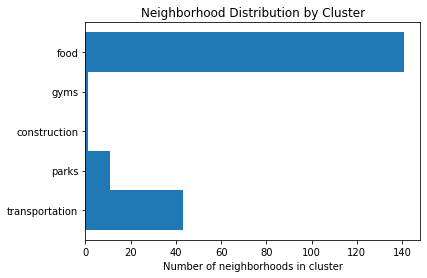

In [51]:
# Visualize cluster distribution

# set bins to be centered at integer values
bins = np.arange(0, clustered_neighborhoods['Cluster Labels'].max() + 1.5) - 0.5

# plot distribution
clustered_neighborhoods['Cluster Labels'].plot(kind="hist", bins=bins, title="Neighborhood Distribution by Cluster", orientation="horizontal")
plt.yticks(np.arange(0, 5, 1), ['transportation', 'parks', 'construction', 'gyms', 'food'])
plt.xlabel('Number of neighborhoods in cluster')
plt.show()

## 5. Conclusion
<a id="conclusion"></a>

k-Means clustering (k=5) of Toronto neighborhoods produced reasonable results, grouping neighborhoods roughly by hubs of transportation, food, parks, construction, and gyms. This tells a story about how a financial center of a country has distributed its resources.

This analysis of neighborhood clustering by venue distribution can be extrapolated to any financial center for broader comparison.

One could also consider optimizing radius input in Foursquare API requests.